In [2]:
import sys
sys.path.append('/Users/jayren/Desktop/Pair Trading/Option Functions')
import pandas as pd
import options_functions as of


pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Don't wrap rows

window = 21  # Rolling window size for volatility calculations
delta = 0.05  # Delta for first exit volatility calculation
symbol = 'aapl'.upper()

df=of.fetch_data(symbol, '2024-01-01', '2026-12-31')
log_retunr=of.compute_log_returns(df)

ctc=of.close_to_close_vol(df, window)
park=of.parkinson_vol(df, window)
yz=of.yang_zhang_volatility(df, window)
rf=of.rolling_first_exit(df, window, delta)

#of.plot_volatility_plotly(df, ctc, park, yz,rf, symbol, window)

all_calls, all_puts = of.get_all_option_data(symbol, 0.05)
# of.plot_volatility_surface(all_calls, symbol)


calls, puts, stock = of.get_options('GOOGL', '2025-07-25')
print(calls)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


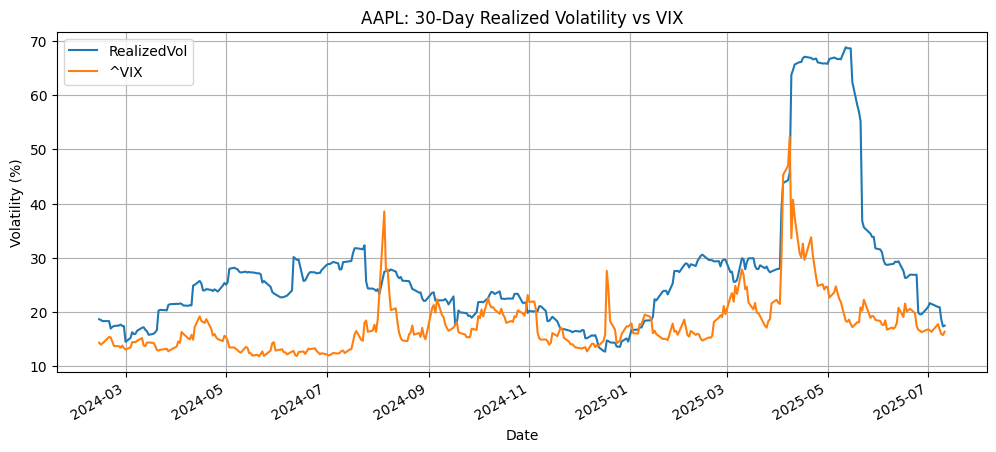

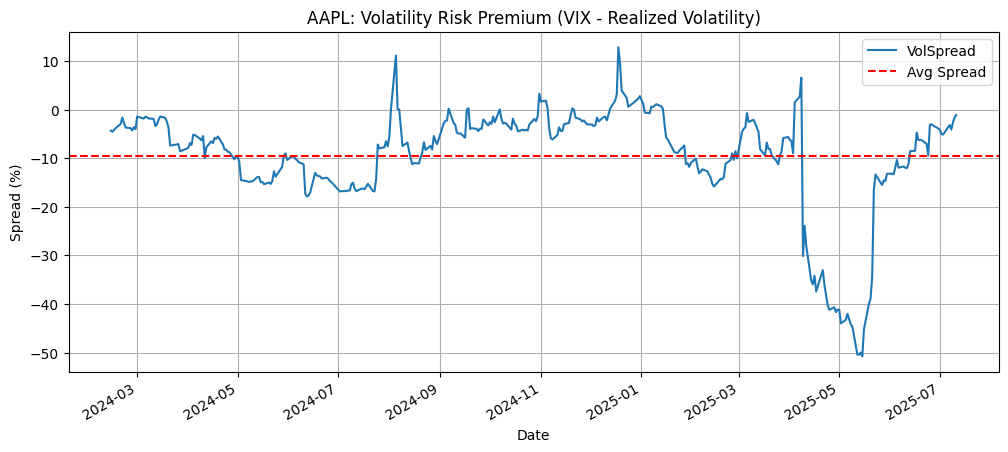

,RealizedVol,^VIX,VolSpread
Date,,,
2024-02-14,0.186898,0.1438,-4.309763
2024-02-15,0.185673,0.1401,-4.557330
2024-02-16,0.183506,0.1424,-4.110621
2024-02-20,0.183526,0.1542,-2.932625
2024-02-21,0.169709,0.1534,-1.630885
...,...,...,...
2025-07-07,0.209631,0.1779,-3.173096
2025-07-08,0.209144,0.1681,-4.104430
2025-07-09,0.185848,0.1594,-2.644846


In [30]:
import sys
sys.path.append('/Users/jayren/Desktop/Pair Trading/Option Functions')
import pandas as pd
import options_functions as of

symbol = 'AAPL'.upper()

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Don't wrap rows

df=of.fetch_data(symbol, '2020-01-01', '2026-12-31')
ya=of.yang_zhang_volatility_multi_windows(df, [5, 10, 20, 30, 60, 90, 120, 180,240, 360])

of.plot_volatility_cone_yz(ya,symbol)

of.plot_stock_volatility_vs_vix(symbol, '2024-01-01', '2026-01-01', 30)


In [26]:
import yfinance as yf
import pandas as pd
from datetime import datetime

ticker = "AAPL"
stock = yf.Ticker(ticker)
expirations = stock.options
current_price = stock.history(period="1d")["Close"].iloc[-1]

atm_iv_data = []

for expiry in expirations:
    try:
        opt_chain = stock.option_chain(expiry)
        calls = opt_chain.calls
        puts = opt_chain.puts

        all_strikes = pd.concat([calls['strike'], puts['strike']]).drop_duplicates()
        atm_strike = all_strikes.iloc[(all_strikes - current_price).abs().argsort()].iloc[0]

        call_row = calls[calls['strike'] == atm_strike].copy()
        put_row = puts[puts['strike'] == atm_strike].copy()

        if not call_row.empty and not put_row.empty:
            call_iv = call_row['impliedVolatility'].values[0]
            put_iv = put_row['impliedVolatility'].values[0]
            avg_iv = (call_iv + put_iv) / 2
            tte = (datetime.strptime(expiry, "%Y-%m-%d") - datetime.today()).days

            atm_iv_data.append({
                "Expiry": expiry,
                "ATM Strike": atm_strike,
                "Call IV": call_iv,
                "Put IV": put_iv,
                "Avg IV": avg_iv,
                "Days to Expiry": tte
            })
    except Exception:
        continue

iv_df = pd.DataFrame(atm_iv_data).sort_values("Days to Expiry")
print(iv_df)

        Expiry  ATM Strike   Call IV    Put IV    Avg IV  Days to Expiry
0   2025-07-18       210.0  0.234749  0.224373  0.229561               5
1   2025-07-25       210.0  0.242683  0.224983  0.233833              12
2   2025-08-01       210.0  0.317817  0.291023  0.304420              19
3   2025-08-08       210.0  0.307563  0.282234  0.294898              26
4   2025-08-15       210.0  0.298225  0.275520  0.286872              33
5   2025-08-22       210.0  0.295112  0.270881  0.282997              40
6   2025-09-19       210.0  0.288520  0.249397  0.268959              68
7   2025-10-17       210.0  0.291084  0.241890  0.266487              96
8   2025-11-21       210.0  0.303291  0.247230  0.275261             131
9   2025-12-19       210.0  0.303565  0.242714  0.273140             159
10  2026-01-16       210.0  0.304298  0.238960  0.271629             187
11  2026-02-20       210.0  0.309333  0.238594  0.273964             222
12  2026-03-20       210.0  0.311134  0.237206  0.2

In [33]:
import yfinance as yf
import pandas as pd

def fetch_option_metrics(symbol: str, expiry: str, strike: float):
    # Fetch stock data
    stock = yf.Ticker(symbol)
    spot = stock.history(period="1d")['Close'].iloc[-1]

    # Get option chain for given expiry
    options = stock.option_chain(expiry)
    calls = options.calls
    puts = options.puts

    # Filter for the specific strike
    call = calls[calls['strike'] == strike].copy()
    put = puts[puts['strike'] == strike].copy()

    if call.empty or put.empty:
        print(f"Strike {strike} not available for {symbol} on {expiry}")
        return

    # Calculate midprice and straddle cost
    call['midprice'] = (call['bid'] + call['ask']) / 2
    put['midprice'] = (put['bid'] + put['ask']) / 2
    straddle_cost = call['midprice'].values[0] + put['midprice'].values[0]

    # Calculate IV skew
    iv_skew = call['impliedVolatility'].values[0] - put['impliedVolatility'].values[0]

    # Output
    print(f"Underlying: {symbol} @ {spot:.2f}")
    print(f"Expiry: {expiry}")
    print(f"Strike: {strike}")
    print(f"Call IV: {call['impliedVolatility'].values[0]:.4f}")
    print(f"Put IV: {put['impliedVolatility'].values[0]:.4f}")
    print(f"IV Skew (Call - Put): {iv_skew:.4f}")
    print(f"Call Mid: ${call['midprice'].values[0]:.2f}")
    print(f"Put Mid: ${put['midprice'].values[0]:.2f}")
    print(f"Straddle Cost: ${straddle_cost:.2f}")

# Example usage
fetch_option_metrics("AAPL", "2025-08-01", 210.0)


Underlying: AAPL @ 211.16
Expiry: 2025-08-01
Strike: 210.0
Call IV: 0.3257
Put IV: 0.2982
IV Skew (Call - Put): 0.0275
Call Mid: $6.92
Put Mid: $5.25
Straddle Cost: $12.18
